# Importing Libraries

In [1]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2                     
import os                  
from random import shuffle
from tqdm import tqdm  
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Loading Images in Directory

In [2]:
# setting path of directory
B_DIR = "C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Basal_cell_carcinoma/train/"
M_DIR =  "C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Melanoma/train/"
N_DIR = "C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Nevus/train/"

Bimages = os.listdir(B_DIR)
Mimages = os.listdir(M_DIR)
Nimages = os.listdir(N_DIR)

# Checking sample images

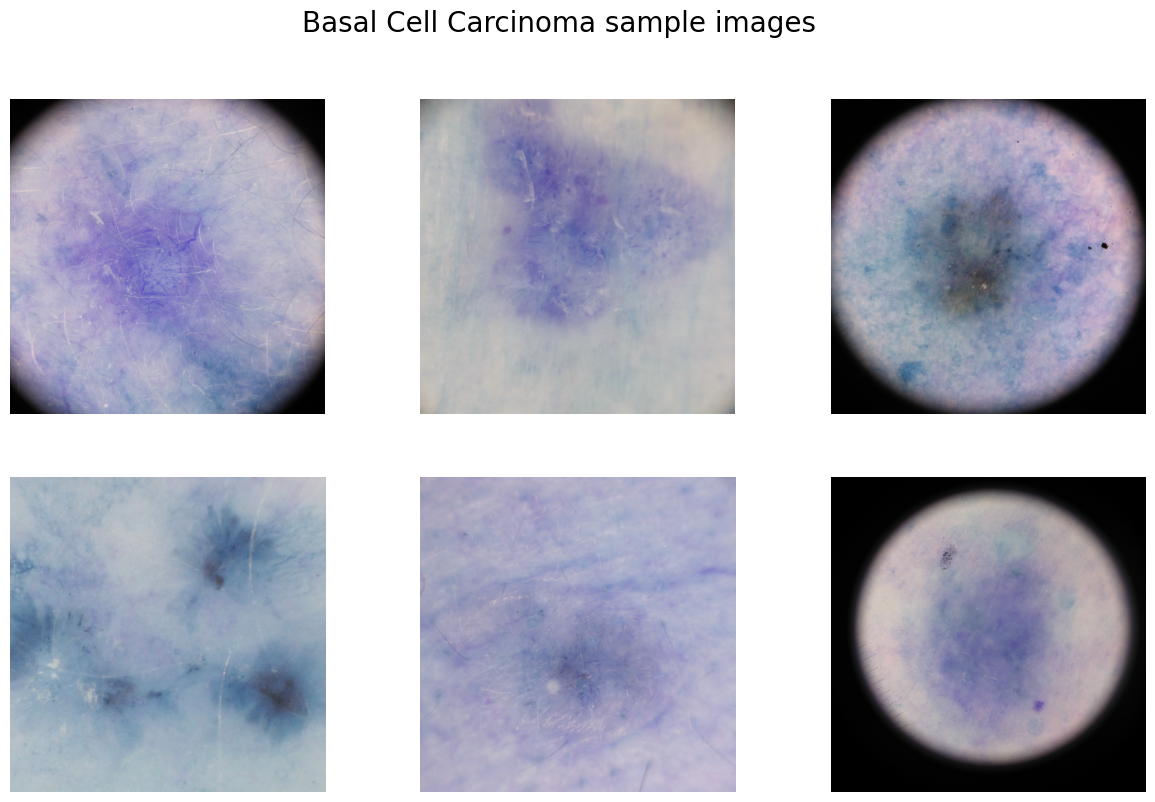

In [3]:
sample_parasite = random.sample(Bimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Basal_cell_carcinoma/train/" +sample_parasite[i])
    
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Basal Cell Carcinoma sample images',fontsize=20)
plt.show()

In [6]:
im = cv2.imread("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Basal_cell_carcinoma/test/bcc_ISIC_0072805.jpg")

In [8]:
im.size , im.shape

(3145728, (1024, 1024, 3))

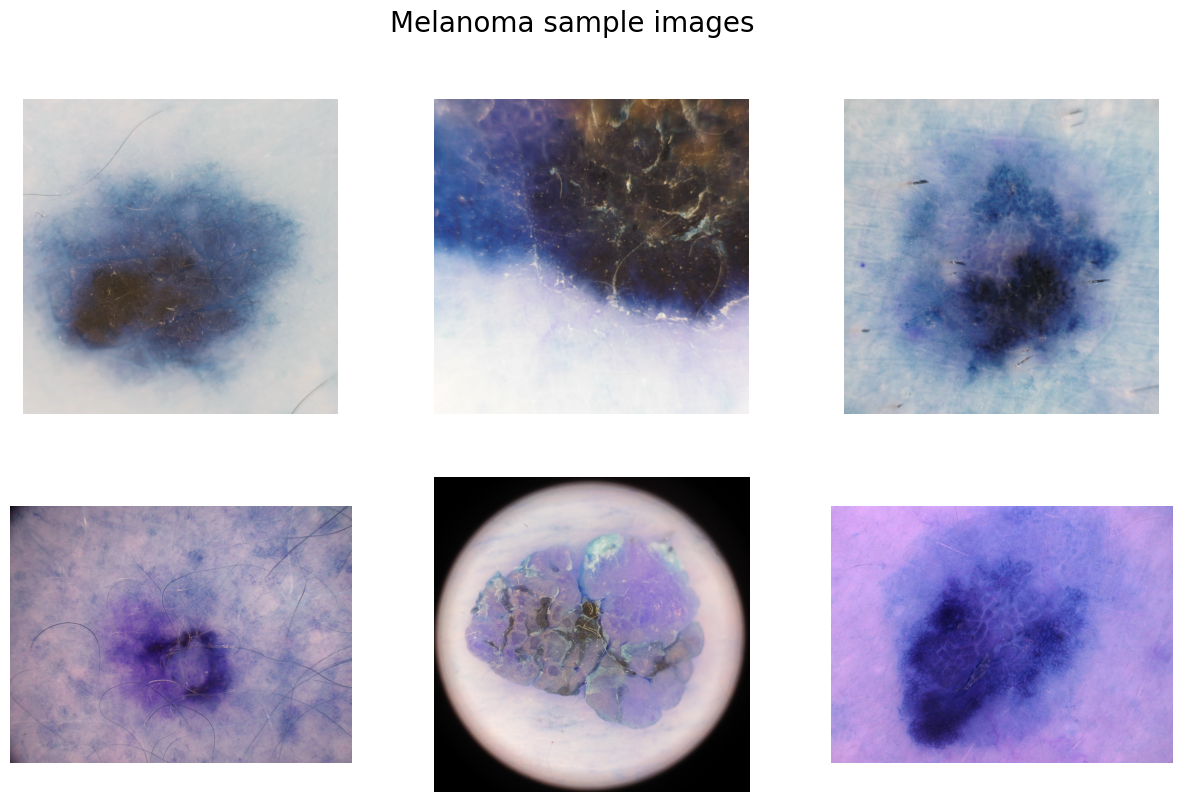

In [5]:
sample_parasite = random.sample(Mimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(M_DIR +sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Melanoma sample images',fontsize=20)
plt.show()

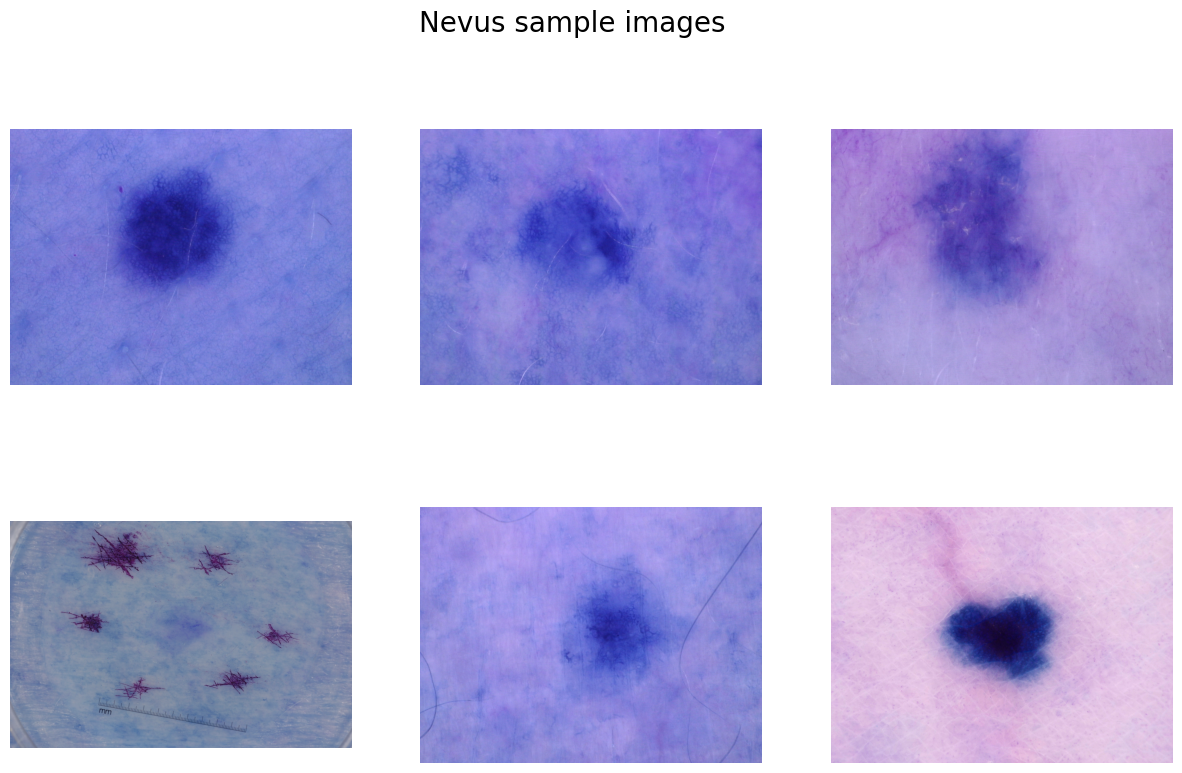

In [6]:
sample_parasite = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(N_DIR +sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Nevus sample images',fontsize=20)
plt.show()

# Data Preparation - Loading Images, Labels and Resizing 

In [ ]:
data=[]
labels=[]
Basal=os.listdir("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Basal_cell_carcinoma/train/")
for a in Basal:
    try:
        image=cv2.imread("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Basal_cell_carcinoma/train/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Melanoma=os.listdir("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Melanoma/train//")
for b in Melanoma:
    try:
        image=cv2.imread("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Melanoma/train/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
Nevus=os.listdir("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Nevus/train//")
for c in Nevus:
    try:
        image=cv2.imread("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Nevus/train/"+c)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(2)
    except AttributeError:
        print("")

In [8]:
#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

# saving features and labels for later re-use
np.save("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/feats_train",feats)
np.save("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/labels_train",labels)

# Loading saved data and labels

In [11]:
feats=np.load("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/feats_train.npy")
labels=np.load("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/labels_train.npy")

# Randomizing Data and Labels

In [12]:
s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]

In [13]:
num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)

12445


In [14]:
print(num_classes)

3


# Train Test Split

In [15]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]

(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

# Image Data Normalization

In [16]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by dividing 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [17]:
y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

# Image Augmentation

In [16]:
trainAug  = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)

# Model Building


In [17]:
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

9406464/9406464 [==============================] - 3s 0us/step


In [18]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [18]:
callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
BS = 64
print("[INFO] training head...")
H = model.fit(
	trainAug.flow(x_train,y_train, batch_size=BS),
	steps_per_epoch=train_len // BS,
	validation_data=(x_test, y_test),
	validation_steps=test_len // BS,
	epochs=30,callbacks=callbacks)

[INFO] training head...
Epoch 1/30
155/155 [==============================] - ETA: 0s - loss: 0.5142 - accuracy: 0.7862 
Epoch 1: val_loss improved from inf to 7.64659, saving model to .mdl_wts.hdf5
155/155 [==============================] - 2251s 14s/step - loss: 0.5142 - accuracy: 0.7862 - val_loss: 7.6466 - val_accuracy: 0.3957 - lr: 0.0010
Epoch 2/30
155/155 [==============================] - ETA: 0s - loss: 0.3820 - accuracy: 0.8415 
Epoch 2: val_loss did not improve from 7.64659
155/155 [==============================] - 2221s 14s/step - loss: 0.3820 - accuracy: 0.8415 - val_loss: 15.1470 - val_accuracy: 0.3881 - lr: 0.0010
Epoch 3/30
155/155 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.8548 
Epoch 3: val_loss improved from 7.64659 to 4.66407, saving model to .mdl_wts.hdf5
155/155 [==============================] - 2737s 18s/step - loss: 0.3622 - accuracy: 0.8548 - val_loss: 4.6641 - val_accuracy: 0.4046 - lr: 0.0010
Epoch 4/30
155/155 [================

# Saving and Loading Model

In [9]:
model = load_model('.mdl_wts.hdf5')
model.save('C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Nevus/model_v1.h5')

In [18]:
model = load_model('C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Nevus/model_v1.h5')
# checking the accuracy 
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

78/78 [==============================] - 147s 2s/step - loss: 0.2113 - accuracy: 0.9550

 Test_Accuracy:- 0.9550020098686218


In [11]:
rounded_predictions = model.predict(x_test, batch_size=16, verbose=0)
rounded_predictions

array([[5.8492972e-08, 7.5584270e-05, 9.9992430e-01],
       [8.5672971e-09, 2.6643111e-05, 9.9997330e-01],
       [1.3412811e-07, 8.1962040e-03, 9.9180365e-01],
       ...,
       [4.0388549e-08, 2.5185607e-03, 9.9748141e-01],
       [3.5441836e-16, 3.4615519e-10, 1.0000000e+00],
       [9.9998474e-01, 1.5219041e-05, 3.2719492e-09]], dtype=float32)

In [19]:
callbacks

156/156 [==============================] - 78s 501ms/step


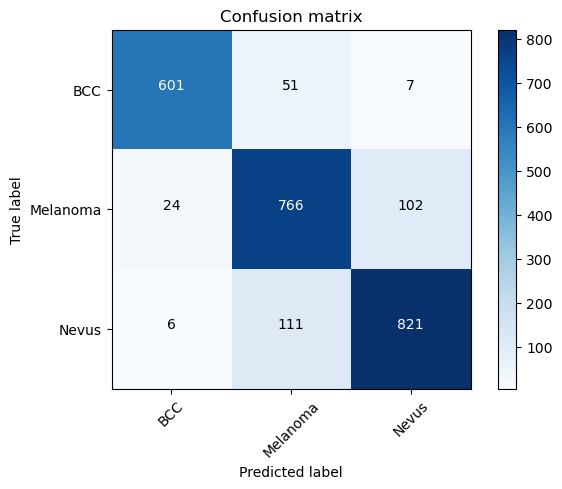

In [24]:
pred = np.argmax(rounded_predictions,axis=1)
rounded_labels=np.argmax(y_test, axis=1)

pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
BS=16
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['BCC','Melanoma','Nevus']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test, batch_size=BS)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis=1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [25]:
predIdxs = model.predict(x_test, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
rounded_labels=np.argmax(y_test, axis=1)

# show a nicely formatted classification report
print(classification_report(rounded_labels, predIdxs,target_names=['BCC','Melanoma','Nevus']))

156/156 [==============================] - 69s 442ms/step
              precision    recall  f1-score   support

         BCC       0.95      0.91      0.93       659
    Melanoma       0.83      0.86      0.84       892
       Nevus       0.88      0.88      0.88       938

    accuracy                           0.88      2489
   macro avg       0.89      0.88      0.88      2489
weighted avg       0.88      0.88      0.88      2489



# Preparing Test Data

In [27]:
data=[]
labels=[]
Basal=os.listdir("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Basal_cell_carcinoma/test/")
for a in Basal:
    try:
        image=cv2.imread("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Basal_cell_carcinoma/test/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Melanoma=os.listdir("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Melanoma/test/")
for b in Melanoma:
    try:
        image=cv2.imread("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Melanoma/test/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
Nevus=os.listdir("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Nevus/test/")
for c in Nevus:
    try:
        image=cv2.imread("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Nevus/test/"+c)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(2)
    except AttributeError:
        print("")

In [28]:
feats_test=np.array(data)
labels_test=np.array(labels)

np.save("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/feats_test",feats_test)
np.save("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/labels_test",labels_test)

In [29]:
feats_test=np.load("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/feats_test.npy")
labels_test=np.load("C:/Users/pavan/Downloads/ISIC_2019_Training_Input/labels_test.npy")

num_classes=len(np.unique(labels_test))
len_data=len(feats_test)
print(len_data)

150


In [30]:
x_valid = feats_test.astype('float32')/255
y_valid=to_categorical(labels_test,3)

15/15 [==============================] - 2s 121ms/step


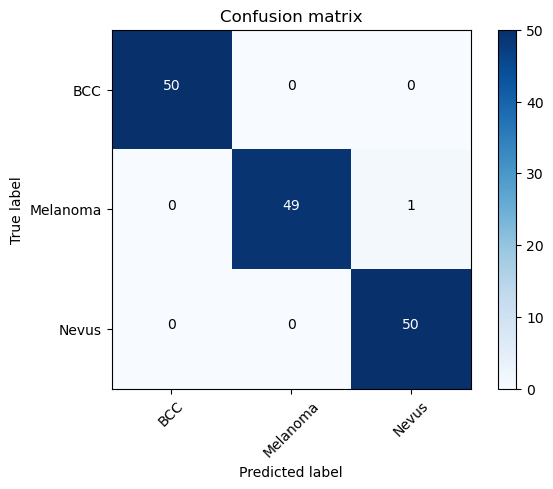

In [31]:
pred_Y = model.predict(x_valid, batch_size = 10, verbose = True)
rounded_predictions = model.predict(x_valid, batch_size=16, verbose=0)
pred = np.argmax(rounded_predictions,axis=1)
rounded_labels=np.argmax(y_valid, axis=1)
BS=10
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['BCC','Melanoma','Nevus']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_valid, batch_size=BS)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis=1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_valid, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [2]:
model = load_model('C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Nevus/model_v1.h5')

In [3]:
img1 = "C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Nevus/test/nv_ISIC_0028145.jpg"
img2 ="C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Melanoma/test/melanoma_ISIC_0071857.jpg"
img3 = "C:/Users/pavan/Downloads/ISIC_2019_Training_Input/Basal_cell_carcinoma/test/bcc_ISIC_0072805.jpg"

In [4]:
class_dict ={0:"Basal_Cell_Carcinoma (Cancer)",
             1:"Melanoma (Cancer)",
             2:"Nevus (Non-Cancerous)"}

In [5]:
from PIL import Image
import numpy as np

def pred_image(img_path, model, class_dict):
    img = Image.open(img_path).resize((224, 224))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32')/255

    preds = model.predict(img_array)[0]
    class_probs = []
    max_prob = 0
    max_class = ''
    for i in range(len(class_dict)):
        class_name = class_dict[i]
        prob = round(preds[i]*100, 2)
        class_probs.append((class_name, prob))
        if prob > max_prob:
            max_prob = prob
            max_class = class_name

    print(f"Prediction: {max_class}")
    return class_probs


In [17]:
pred_image(img1,model,class_dict)

1/1 [==============================] - 1s 568ms/step
Prediction: Nevus (Non-Cancerous)


[('Basal_Cell_Carcinoma (Cancer)', 0.0),
 ('Melanoma (Cancer)', 0.01),
 ('Nevus (Non-Cancerous)', 99.99)]

In [18]:
pred_image(img2,model,class_dict)

1/1 [==============================] - 0s 32ms/step
Prediction: Melanoma (Cancer)


[('Basal_Cell_Carcinoma (Cancer)', 0.21),
 ('Melanoma (Cancer)', 99.79),
 ('Nevus (Non-Cancerous)', 0.0)]

In [19]:
pred_image(img3,model,class_dict)

1/1 [==============================] - 0s 33ms/step
Prediction: Basal_Cell_Carcinoma (Cancer)


[('Basal_Cell_Carcinoma (Cancer)', 99.96),
 ('Melanoma (Cancer)', 0.04),
 ('Nevus (Non-Cancerous)', 0.0)]

# Plotting Sample Predictions

78/78 [==============================] - 41s 522ms/step


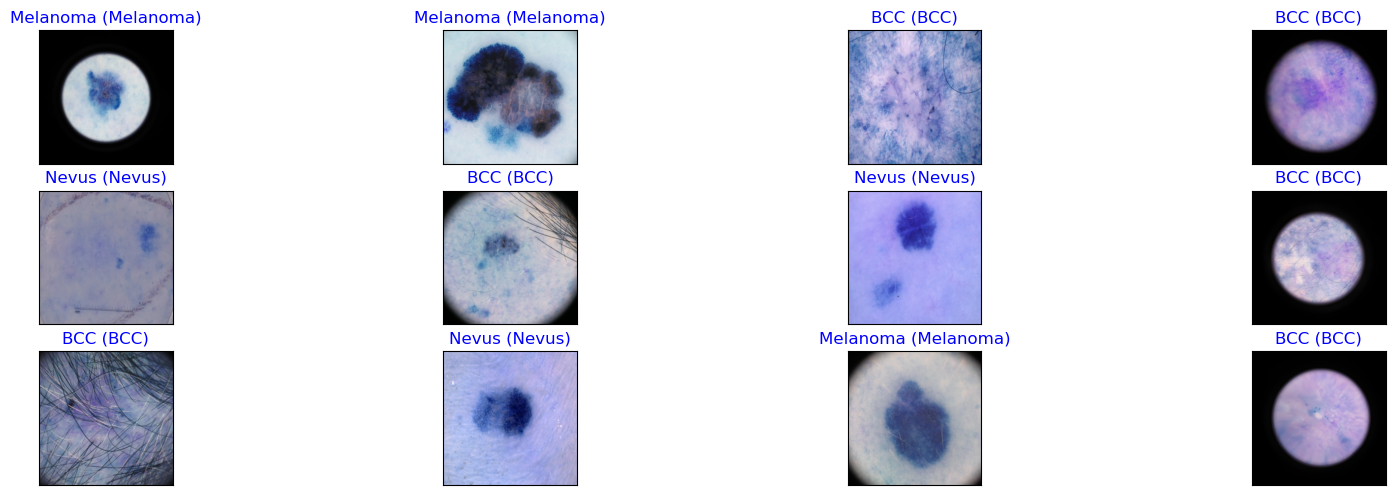

In [44]:
y_hat = model.predict(x_test)

# define text labels 
skin_labels = ['BCC','Melanoma','Nevus']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(skin_labels[pred_idx], skin_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

In [116]:
layer_names=[layer.name for layer in model.layers]

In [117]:
layer_names

['input_1',
 'Conv1',
 'bn_Conv1',
 'Conv1_relu',
 'expanded_conv_depthwise',
 'expanded_conv_depthwise_BN',
 'expanded_conv_depthwise_relu',
 'expanded_conv_project',
 'expanded_conv_project_BN',
 'block_1_expand',
 'block_1_expand_BN',
 'block_1_expand_relu',
 'block_1_pad',
 'block_1_depthwise',
 'block_1_depthwise_BN',
 'block_1_depthwise_relu',
 'block_1_project',
 'block_1_project_BN',
 'block_2_expand',
 'block_2_expand_BN',
 'block_2_expand_relu',
 'block_2_depthwise',
 'block_2_depthwise_BN',
 'block_2_depthwise_relu',
 'block_2_project',
 'block_2_project_BN',
 'block_2_add',
 'block_3_expand',
 'block_3_expand_BN',
 'block_3_expand_relu',
 'block_3_pad',
 'block_3_depthwise',
 'block_3_depthwise_BN',
 'block_3_depthwise_relu',
 'block_3_project',
 'block_3_project_BN',
 'block_4_expand',
 'block_4_expand_BN',
 'block_4_expand_relu',
 'block_4_depthwise',
 'block_4_depthwise_BN',
 'block_4_depthwise_relu',
 'block_4_project',
 'block_4_project_BN',
 'block_4_add',
 'block_5_e